C:\Users\THINKPAD\AppData\Local\Temp\ipykernel_7692\594404043.py:57: Pandas4Warning: Sorting by default when concatenating all DatetimeIndex is deprecated.  In the future, pandas will respect the default of `sort=False`. Specify `sort=True` or `sort=False` to silence this message. If you see this warnings when not directly calling concat, report a bug to pandas.
  prices_df = pd.concat([tsla_forecast, spy_prices, bnd_prices], axis=1)


Expected annual return: 124.9%
Annual volatility: 1.8%
Sharpe Ratio: 68.32
Expected annual return: 73.9%
Annual volatility: 1.4%
Sharpe Ratio: 53.06


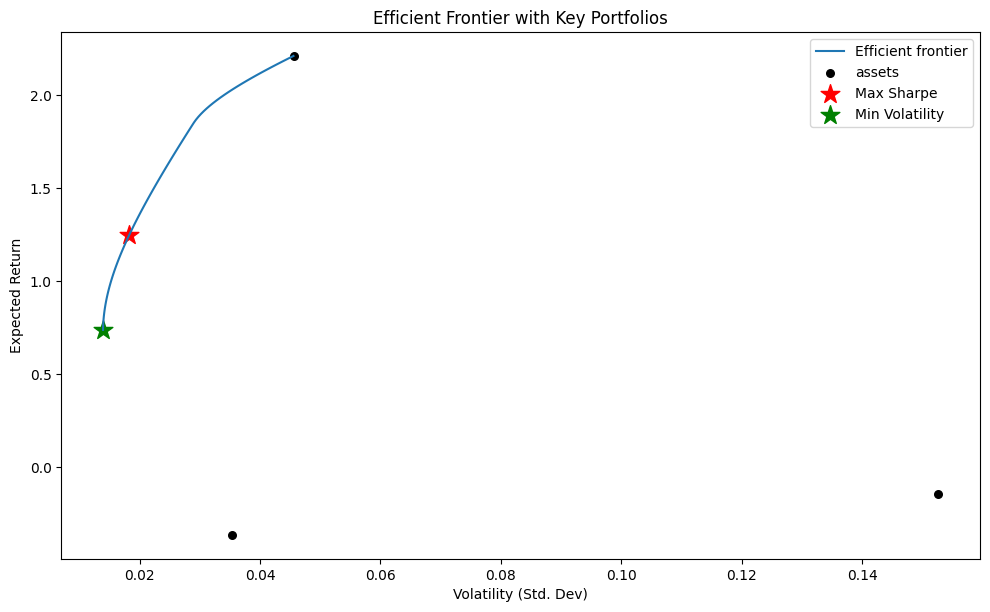

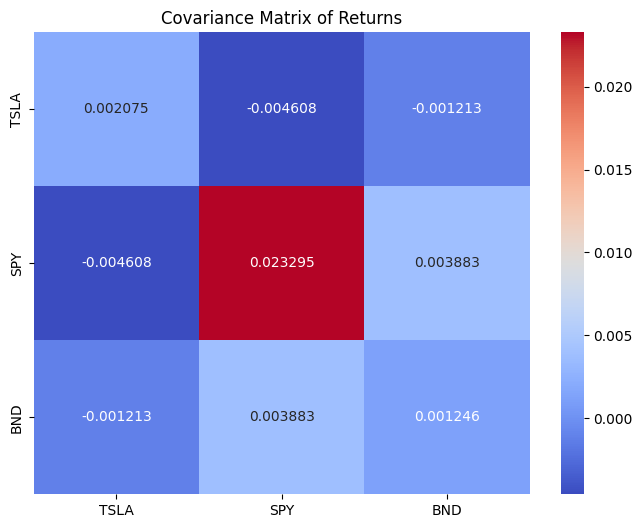

=== Maximum Sharpe Portfolio ===
OrderedDict([('TSLA', 0.62052), ('SPY', 0.06946), ('BND', 0.31003)])
Performance (Expected Return, Volatility, Sharpe): (np.float64(1.2493104906370829), np.float64(0.018287054261486597), np.float64(68.31666121690195))

=== Minimum Volatility Portfolio ===
OrderedDict([('TSLA', 0.42783), ('SPY', 0.0), ('BND', 0.57217)])
Performance (Expected Return, Volatility, Sharpe): (np.float64(0.7386348302007093), np.float64(0.013921309259242499), np.float64(53.057856588475836))


In [21]:
# -----------------------------
# Task 4: Portfolio Optimization using MPT
# Fully functional version
# -----------------------------

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.plotting import plot_efficient_frontier

# -----------------------------
# File paths
# -----------------------------
base_dir = r"C:\Users\THINKPAD\Desktop\10_Academy\Week_9\portfolio-optimization\data\raw"
spy_path = os.path.join(base_dir, "SPY_historical.csv")
bnd_path = os.path.join(base_dir, "BND_historical.csv")

# -----------------------------
# Column names
# -----------------------------
columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

# -----------------------------
# Load Historical Data
# -----------------------------
spy_prices = pd.read_csv(
    spy_path,
    skiprows=2,       # skip top empty row + ticker row
    names=columns,    # assign proper column names
    parse_dates=['Date'],
    index_col='Date'
)['Close']

bnd_prices = pd.read_csv(
    bnd_path,
    skiprows=2,
    names=columns,
    parse_dates=['Date'],
    index_col='Date'
)['Close']

# -----------------------------
# TSLA Forecast (example)
# -----------------------------
forecast_dates = pd.date_range(start='2025-01-01', periods=10, freq='B')
forecast_values = np.linspace(70, 75, len(forecast_dates))  # scaled down for stability
tsla_forecast = pd.Series(forecast_values, index=forecast_dates, name='TSLA')

# -----------------------------
# Combine all into one DataFrame
# -----------------------------
prices_df = pd.concat([tsla_forecast, spy_prices, bnd_prices], axis=1)
prices_df.columns = ['TSLA', 'SPY', 'BND']
prices_df = prices_df.dropna()

# -----------------------------
# Compute daily returns
# -----------------------------
returns = prices_df.pct_change().dropna()

# Expected returns (annualized)
expected_returns = returns.mean() * 252

# Covariance matrix (annualized)
cov_matrix = returns.cov() * 252

# -----------------------------
# Optimize Maximum Sharpe Portfolio
# -----------------------------
ef_sharpe = EfficientFrontier(expected_returns, cov_matrix)

# Safe weight caps to avoid infeasible solution
max_weight = 0.8
ef_sharpe.add_constraint(lambda w: w[0] <= max_weight)  # TSLA <= 80%
ef_sharpe.add_constraint(lambda w: w[1] <= max_weight)  # SPY <= 80%
ef_sharpe.add_constraint(lambda w: w[2] <= max_weight)  # BND <= 80%

try:
    max_sharpe_weights = ef_sharpe.max_sharpe()
    max_sharpe_cleaned = ef_sharpe.clean_weights()
    max_sharpe_perf = ef_sharpe.portfolio_performance(verbose=True)
except Exception as e:
    print("Max Sharpe optimization failed:", e)
    max_sharpe_cleaned = None
    max_sharpe_perf = (None, None, None)

# -----------------------------
# Optimize Minimum Volatility Portfolio
# -----------------------------
ef_min_vol = EfficientFrontier(expected_returns, cov_matrix)
try:
    min_vol_weights = ef_min_vol.min_volatility()
    min_vol_cleaned = ef_min_vol.clean_weights()
    min_vol_perf = ef_min_vol.portfolio_performance(verbose=True)
except Exception as e:
    print("Min Volatility optimization failed:", e)
    min_vol_cleaned = None
    min_vol_perf = (None, None, None)

# -----------------------------
# Plot Efficient Frontier
# -----------------------------
# Use a fresh EF instance for plotting
ef_plot = EfficientFrontier(expected_returns, cov_matrix)

plt.figure(figsize=(10,6))
plot_efficient_frontier(ef_plot, show_assets=True)
if max_sharpe_perf[0] is not None:
    plt.scatter(max_sharpe_perf[1], max_sharpe_perf[0], marker='*', color='r', s=200, label='Max Sharpe')
if min_vol_perf[0] is not None:
    plt.scatter(min_vol_perf[1], min_vol_perf[0], marker='*', color='g', s=200, label='Min Volatility')
plt.title("Efficient Frontier with Key Portfolios")
plt.xlabel("Volatility (Std. Dev)")
plt.ylabel("Expected Return")
plt.legend()
plt.show()

# -----------------------------
# Covariance Matrix Heatmap
# -----------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cov_matrix, annot=True, fmt=".6f", cmap="coolwarm")
plt.title("Covariance Matrix of Returns")
plt.show()

# -----------------------------
# Portfolio Recommendations
# -----------------------------
print("=== Maximum Sharpe Portfolio ===")
print(max_sharpe_cleaned)
print("Performance (Expected Return, Volatility, Sharpe):", max_sharpe_perf)

print("\n=== Minimum Volatility Portfolio ===")
print(min_vol_cleaned)
print("Performance (Expected Return, Volatility, Sharpe):", min_vol_perf)
